<a href="https://colab.research.google.com/github/AnasNedday/RecommandationBasedUsers/blob/main/RecommandationSystemBasedUsersRatings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import gc

### Chargement des données


In [4]:
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

In [5]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Pearson :
Maintenant le principe est de créer une méthode **pearson_similarity** qui permet de réaliser un système de recommandation basés sur le voisinage :
##### La formule est la suivante :  
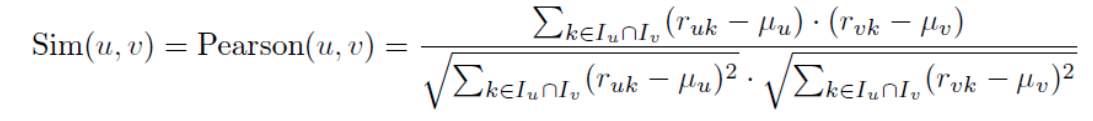

In [18]:
from sklearn.neighbors import NearestNeighbors
class System_Recommender():
  """
    Système de recommandation collaboratif basé sur la similarité utilisateur-utilisateur
    en utilisant la corrélation de Pearson.
  """
  def __init__(self, path_movies, path_ratings):
    """
        Initialisation du modèle de recommandation avec les chemins des fichiers de films et d'évaluations.

        movies_path: chemin vers le fichier des films
        ratings_path: chemin vers le fichier des évaluations des utilisateurs
    """
    self.path_movies = path_movies
    self.path_ratings = path_ratings
    self.movie_rating_thres = 50  # Minimum d'évaluation pour un film
    self.user_rating_thres = 50   # Minimum d'évaluation d'un utilisateur
    self.model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

  def _prep_data(self):
    """
        Chargement des données, prétraitement et préparation des données pour le modèle.
    """

    df_movies = pd.read_csv(self.path_movies, usecols=['movieId', 'title'], dtype={'movieId': 'int32', 'title': 'str'})
    df_ratings = pd.read_csv(self.path_ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})


    df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(),columns=['count'])
    popular_movies = list(set(df_movies_cnt.query('count >= @self.movie_rating_thres').index))
    movies_filter = df_ratings.movieId.isin(popular_movies).values

    # Filtrer les utilisateurs actifs avec un seuil de nombre de notations
    df_users_cnt = pd.DataFrame(
    df_ratings.groupby('userId').size(),columns=['count'])
    active_users = list(set(df_users_cnt.query('count >= @self.user_rating_thres').index))
    users_filter = df_ratings.userId.isin(active_users).values

    # Filtrer les évaluations basées sur les films populaires et les utilisateurs
    df_ratings_filtered = df_ratings[movies_filter & users_filter]

    user_movie_mat = df_ratings_filtered.pivot(
    index='userId', columns='movieId', values='rating').fillna(0)

    del df_movies, df_movies_cnt, df_users_cnt
    gc.collect()

    return user_movie_mat, df_ratings_filtered


  def _set_filter_params(self, movie_rating_thres, user_rating_thres):
        self.movie_rating_thres = movie_rating_thres
        self.user_rating_thres = user_rating_thres


  def _pearson_similarity(self, user_1_ratings, user_2_ratings):
    """
        Calculer la similarité entre deux utilisateurs avec la corrélation de Pearson.

        user_1_ratings: évaluation du premier utilisateur
        user_2_ratings: évaluation du second utilisateur

        Retourne la corrélation de Pearson entre les deux utilisateurs.
    """
    # Get the common movie IDs rated by both users
    common_movie_ids = user_1_ratings.index.intersection(user_2_ratings.index)

    # If there are no common movies, similarity is 0
    if len(common_movie_ids) == 0:
        return 0

    # Get the ratings for the common movies for both users
    user_1_common_ratings = user_1_ratings.loc[common_movie_ids]
    user_2_common_ratings = user_2_ratings.loc[common_movie_ids]

    # Calculate Pearson correlation
    mean_user_1 = np.mean(user_1_common_ratings)
    mean_user_2 = np.mean(user_2_common_ratings)

    numerator = np.sum((user_1_common_ratings - mean_user_1) * (user_2_common_ratings - mean_user_2))
    denominator = np.sqrt(np.sum(np.square(user_1_common_ratings - mean_user_1))) * np.sqrt(np.sum(np.square(user_2_common_ratings - mean_user_2)))

    if denominator == 0:
        return 0

    return numerator / denominator
  def _inference(self, user_movie_mat, user_id, n_recommendations):

        user_u = user_movie_mat.loc[user_id]

        # Calculer la similarité entre l'utilisateur u et tous les autres utilisateurs
        similarities = {}
        for other_user_id in user_movie_mat.index:
            if other_user_id != user_id:
                user_v = user_movie_mat.loc[other_user_id]
                sim = self._pearson_similarity(user_u, user_v)
                similarities[other_user_id] = sim

        # Trier les utilisateurs similaires par score de similarité
        similar_users = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

        recommended_movies = []
        for similar_user_id, _ in similar_users:
            movies_watched_by_similar_user = user_movie_mat.loc[similar_user_id]
            # Trouver les films que l'utilisateur similaire a notés, mais que l'utilisateur courant n'a pas encore vus
            movies_not_watched = movies_watched_by_similar_user[
                (movies_watched_by_similar_user > 0) & (user_u == 0)]
            recommended_movies.extend(movies_not_watched.index)

            if len(recommended_movies) >= n_recommendations:
                break

        return recommended_movies[:n_recommendations]


  def _make_user_recommendations(self, user_id, n_recommendations):
        user_movie_mat, df_ratings_filtered = self._prep_data()
        recommended_movie_ids = self._inference(user_movie_mat, user_id, n_recommendations)

        # Obtenir les titres des films recommandés
        df_movies = pd.read_csv(self.path_movies, usecols=['movieId', 'title'])
        recommended_movies = df_movies[df_movies['movieId'].isin(recommended_movie_ids)]

        return recommended_movies['title'].tolist()







In [19]:
if __name__ == "__main__":
    recommender = System_Recommender(path_movies='/content/movies.csv', path_ratings='/content/ratings.csv')

    # Paramètres de filtrage (optionnels)
    recommender._set_filter_params(movie_rating_thres=50, user_rating_thres=10)

    # Faire des recommandations pour l'utilisateur avec l'ID 1
    recommendations = recommender._make_user_recommendations(user_id=1, n_recommendations=10)

    print(f"Films recommandés pour l'utilisateur 1 : {recommendations}")

Films recommandés pour l'utilisateur 1 : ['Casino (1995)', 'Sense and Sensibility (1995)', 'Get Shorty (1995)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Clueless (1995)', 'Broken Arrow (1996)', 'Bad Boys (1995)', 'Natural Born Killers (1994)', 'Crow, The (1994)', 'Maverick (1994)']
